# Introduction

In this project, we apply K-means clustering to user activity data, using both scaling and Principal Component Analysis (PCA) for preprocessing. Our analysis focuses on the comparison of clustering performance between scaled and PCA-transformed data, employing metrics like the silhouette, Calinski-Harabasz, and Davies-Bouldin scores to assess cluster quality. This notebook outlines our approach and findings.

In our approach, we cluster daily activity data, comprising 940 entries from 33 individuals. By analyzing each day as a distinct sample, we assume these daily records represent the broader population's behavior patterns. This method allows us to identify activity trends and categorize days based on similar activity characteristics within our dataset.

# Packages & Raw Data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

import warnings


# Raw Data

In [2]:
# Data import
data_original = pd.read_csv('dailyActivity_merged.csv')

In [3]:
# First 5 rows
data_original.head(5)

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,4/12/2016,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,4/13/2016,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,4/14/2016,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776
3,1503960366,4/15/2016,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745
4,1503960366,4/16/2016,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863


In [4]:
#Summary Function
pd.options.display.float_format = '{:,.2f}'.format
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['count'] = df.count().values
    summ['#missing'] = df.isnull().sum().values
    summ['%missing'] = df.isnull().sum().values / len(df) * 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['average'] = desc['mean'].values
    summ['standard_deviation'] = desc['std'].values
    return summ

print('\033[93m\033[1m' + 'Summary Table: ' + '\033[0m')
summary(data_original)

Summary Table: 
data shape: (940, 15)


,data type,count,#missing,%missing,#unique,min,max,average,standard_deviation
Id,int64,940,0,0.00,33,"1,503,960,366.00","8,877,689,391.00","4,855,407,369.33","2,424,805,475.66"
ActivityDate,object,940,0,0.00,31,NaN,NaN,NaN,NaN
TotalSteps,int64,940,0,0.00,842,0.00,"36,019.00","7,637.91","5,087.15"
TotalDistance,float64,940,0,0.00,615,0.00,28.03,5.49,3.92
TrackerDistance,float64,940,0,0.00,613,0.00,28.03,5.48,3.91
LoggedActivitiesDistance,float64,940,0,0.00,19,0.00,4.94,0.11,0.62
VeryActiveDistance,float64,940,0,0.00,333,0.00,21.92,1.50,2.66
ModeratelyActiveDistance,float64,940,0,0.00,211,0.00,6.48,0.57,0.88
LightActiveDistance,float64,940,0,0.00,491,0.00,10.71,3.34,2.04
SedentaryActiveDistance,float64,940,0,0.00,9,0.00,0.11,0.00,0.01


# Data Pre-processing

The dataset comprises 940 unique entries from 33 individuals. We've selected key columns for our analysis, which include 'ActivityDate', 'TotalSteps', 'VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes', 'SedentaryMinutes', and 'Calories'. Our focus will primarily be on 'TotalSteps', 'TotalDistance', 'VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes', 'SedentaryMinutes', and 'Calories', as these metrics are crucial for understanding activity patterns. Upon examining the data, no significant outliers, missing values, or problematic data were detected, so no further data cleaning is necessary.








In [5]:
# Filtering chosen columns
columns_chosen = ['TotalSteps', 'TotalDistance', 'VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes', 'SedentaryMinutes', 'Calories' ]
data = data_original[columns_chosen].copy()

In [6]:
data.head(5)

,TotalSteps,TotalDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,13162,8.50,25,13,328,728,1985
1,10735,6.97,21,19,217,776,1797
2,10460,6.74,30,11,181,1218,1776
3,9762,6.28,29,34,209,726,1745
4,12669,8.16,36,10,221,773,1863


In [7]:
summary(data)

data shape: (940, 7)


,data type,count,#missing,%missing,#unique,min,max,average,standard_deviation
TotalSteps,int64,940,0,0.00,842,0.00,"36,019.00","7,637.91","5,087.15"
TotalDistance,float64,940,0,0.00,615,0.00,28.03,5.49,3.92
VeryActiveMinutes,int64,940,0,0.00,122,0.00,210.00,21.16,32.84
FairlyActiveMinutes,int64,940,0,0.00,81,0.00,143.00,13.56,19.99
LightlyActiveMinutes,int64,940,0,0.00,335,0.00,518.00,192.81,109.17
SedentaryMinutes,int64,940,0,0.00,549,0.00,"1,440.00",991.21,301.27
Calories,int64,940,0,0.00,734,0.00,"4,900.00","2,303.61",718.17


# Exploratory Data Analysis

Color palettes for visualization

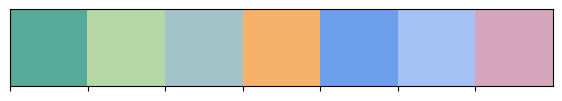

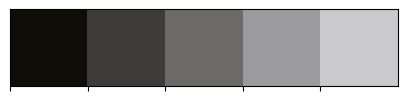

In [8]:
# Color paletttes for visualization
color_palette = sns.color_palette(["#5A9", "#B6D7A8", "#A2C4C9",
                                   "#F6B26B", "#6D9EEB", "#A4C2F4",
                                   "#D5A6BD",
                                   ])

sns.palplot(color_palette)
plt.show()

black_palette = ['#100C07', '#3E3B39', '#6D6A6A', '#9B9A9C', '#CAC9CD']
sns.palplot(black_palette)
plt.show()

 Data Distribution : TotalSteps


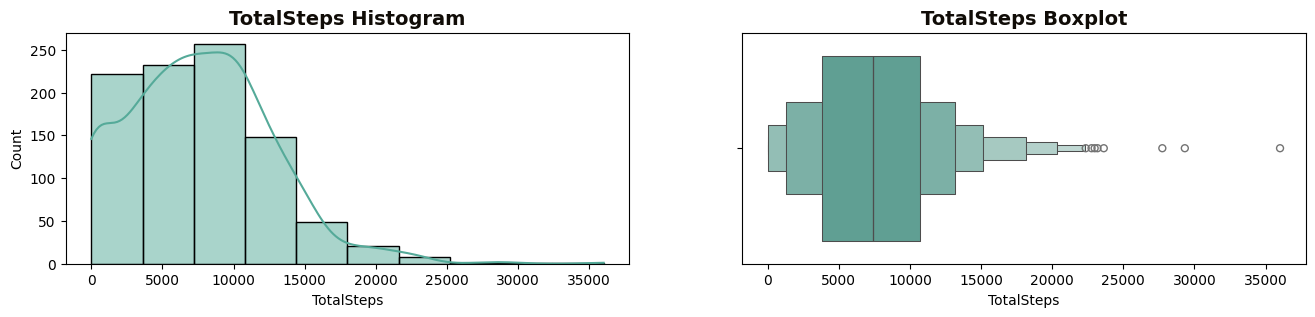



 Data Distribution : TotalDistance


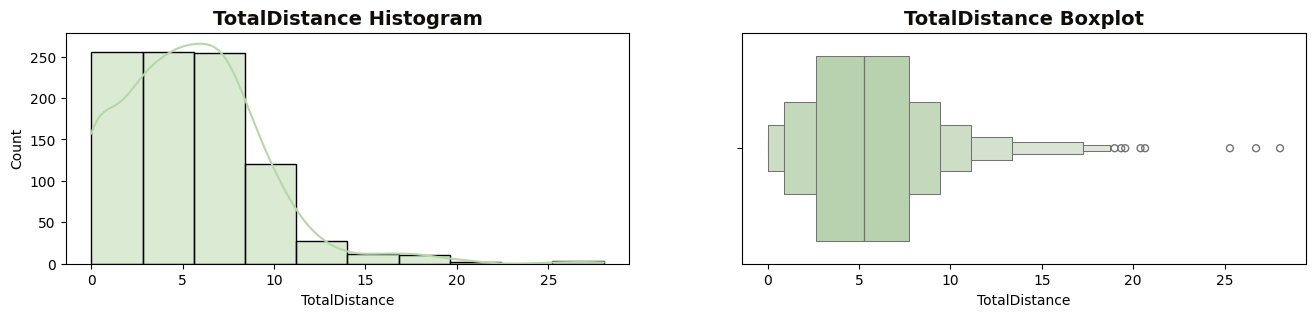



 Data Distribution : VeryActiveMinutes


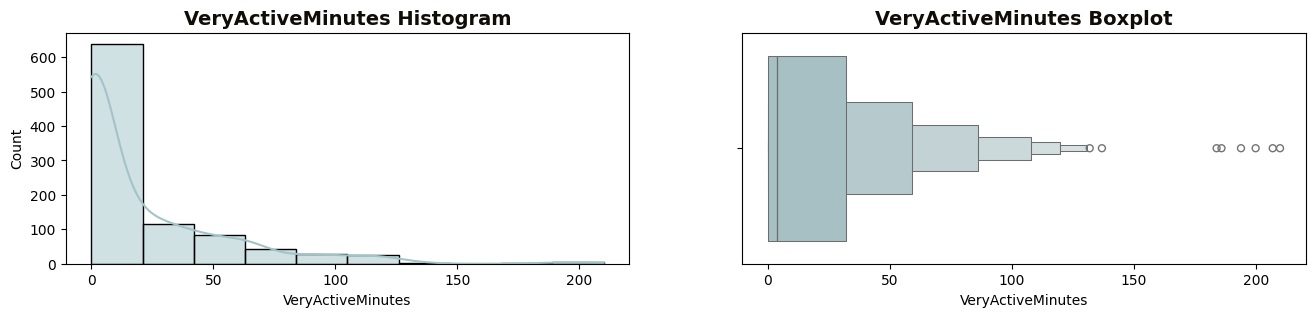



 Data Distribution : FairlyActiveMinutes


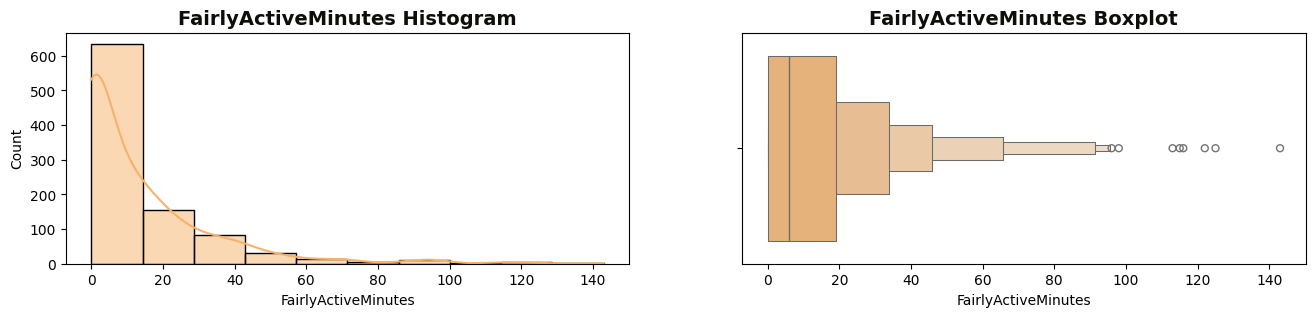



 Data Distribution : LightlyActiveMinutes


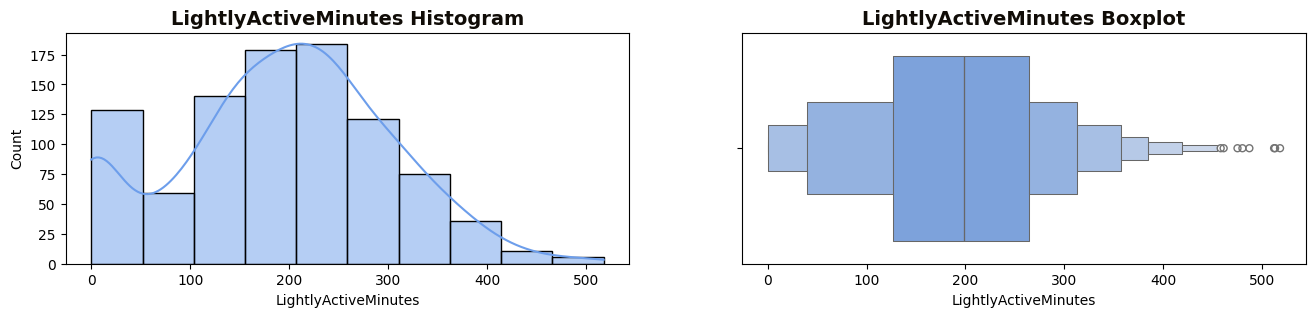



 Data Distribution : SedentaryMinutes


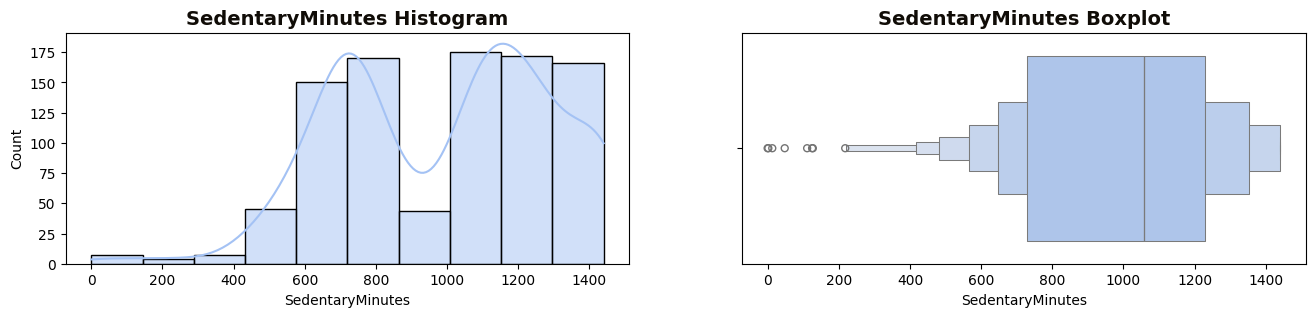



 Data Distribution : Calories


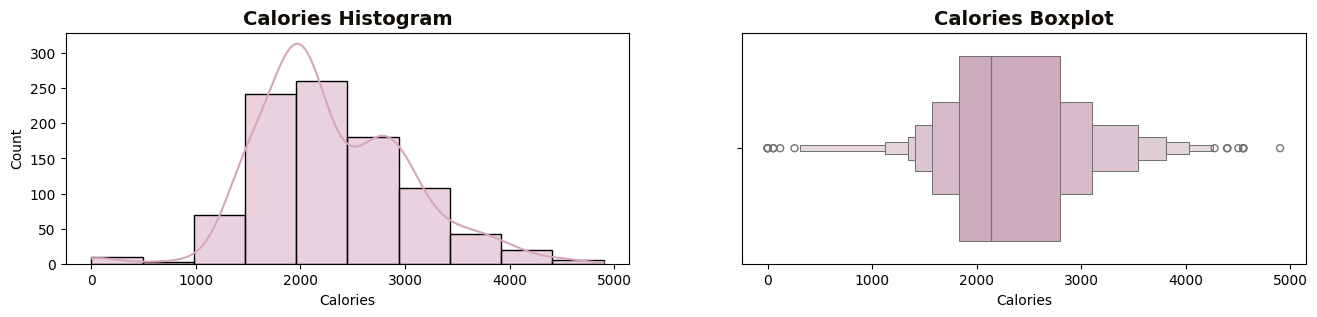

In [9]:
#Data distributions
warnings.simplefilter(action='ignore', category=FutureWarning)

for color, column in enumerate(data.columns):
  print(f'\033[93m\033[1m Data Distribution : {column}\033[0m')
  plt.figure(figsize=(16, 3))

  plt.subplot(1, 2, 1)
  sns.histplot(data[column], kde=True, bins= 10, color = color_palette[color])
  plt.title(f'{column} Histogram', fontweight = 'bold', fontsize = 14, fontfamily = 'sans-serif', color = black_palette[0])

  plt.subplot(1, 2, 2)
  sns.boxenplot(data=data, x=column, color = color_palette[color])
  plt.title(f'{column} Boxplot', fontweight = 'bold', fontsize = 14, fontfamily = 'sans-serif', color = black_palette[0])

  plt.show()
  print('\n')

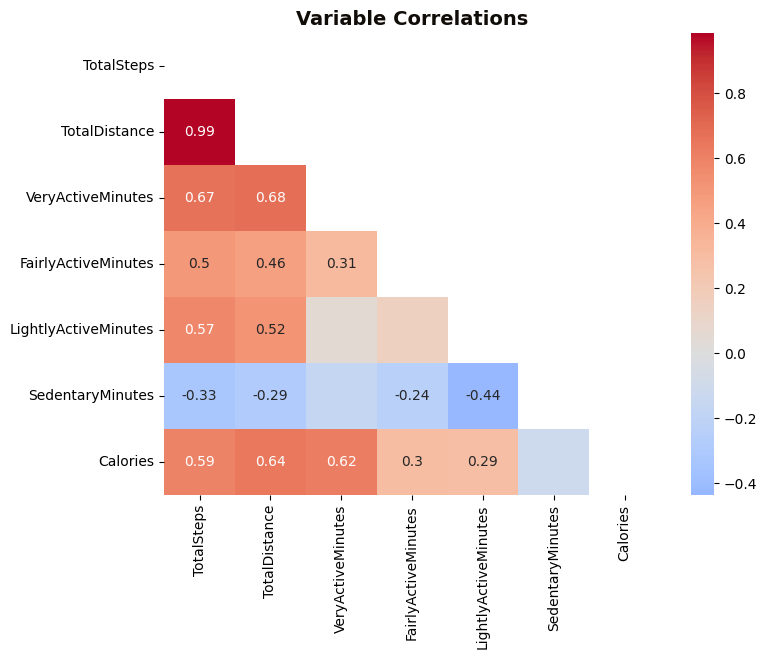

In [10]:
# Correlation heatmap
plt.figure(figsize=(8,6))

correlation_matrix = data.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
annot_mask = (correlation_matrix <= -0.2) | (correlation_matrix >= 0.2)
annot_text = np.where(annot_mask, correlation_matrix.round(2).astype(str), '')

sns.heatmap(correlation_matrix, mask=mask, annot=annot_text, cmap='coolwarm', fmt='', center=0)
plt.title('Variable Correlations', fontweight = 'bold', fontsize = 14, fontfamily = 'sans-serif', color = black_palette[0])

plt.show()

# Clustering

Since the data points are in various units (distance, minutes, calories) with significant range differences, we will first scale our data to normalize these discrepancies.

We will proceed by analyzing both PCA-transformed and non-PCA data. Subsequently, we will calculate silhouette, Calinski-Harabasz, and Davies-Bouldin scores to evaluate which preprocessing method yields better clustering performance.

We will be using K-means clustering. K-means clustering is a popular unsupervised machine learning algorithm used to partition a set of data points into K distinct, non-overlapping clusters. It groups data points into clusters such that the points in each cluster are similar to each other while being different from points in other clusters. The goal is to minimize the variance within each cluster.

## Clustering


**Scaled Data**

In [11]:
# Scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

**Pca Data**

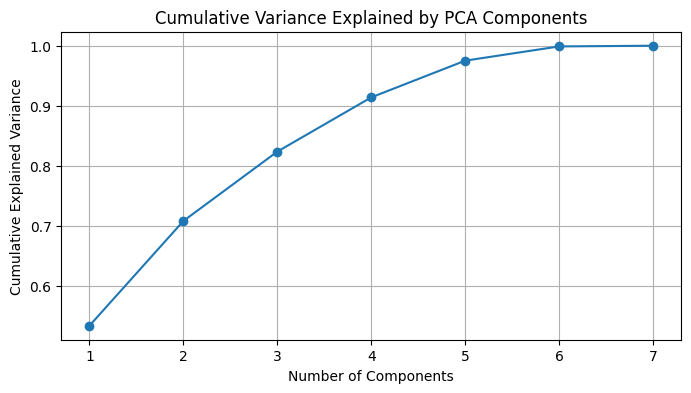



Chosen Number of Components is:  4




,PC1,PC2,PC3,PC4
0,"5,482.84",793.93,102.68,-46.77
1,"3,047.00",775.37,94.30,34.27
2,"2,762.33",739.20,-341.82,20.17


In [12]:
# PCA
pca = PCA()
pca.fit(scaled_data)

# Calculate the cumulative variance explained by each component
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Plot the cumulative variance
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.title('Cumulative Variance Explained by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()


# Choose the number of components that explain at least 90% of the variance
n_components = sum(cumulative_variance < 0.90) + 1

pca = PCA(n_components=n_components)
pca_data = pca.fit_transform(data)

# Create the pca_data
pca_data = pd.DataFrame(data=pca_data, columns=[f'PC{i}' for i in range(1, n_components + 1)])

print('\n')
print(f'Chosen Number of Components is:  {n_components}')

print('\n')
pca_data.head(3)

**Elbow Method**

Deciding on how many clusters will be created.

 Inertia is the sum of squared distances of samples to their closest cluster center. In simple terms, it measures the compactness of the clusters. Lower values of inertia are better as they indicate that the clusters are more dense and well-defined.

 Choosing k at the elbow point ensures that the number of clusters is neither too small to capture the diversity of the data nor too large to overfit the data with too many specific clusters.

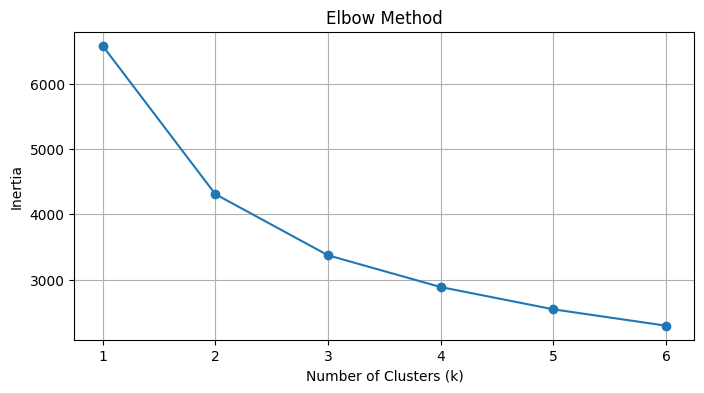

In [13]:
inertia = []
for k in range(1, 7):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(8, 4))
plt.plot(range(1, 7), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(range(1, 7))
plt.grid(True)
plt.show()

3 clusters will be created.

**KMeans Clustering**

In [14]:
# Scaled Data Clustering
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
kmeans.fit(scaled_data)
labels = kmeans.labels_
data['Cluster_Scaled'] = labels

In [15]:
# Pca Data Clustering
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
kmeans.fit(pca_data)
labels = kmeans.labels_
data['Cluster_PCA'] = labels

## Performance Evaluation

Silhouette Score: Measures how similar a point is to its own cluster compared to other clusters. Ranges from -1 (incorrect clustering) to +1 (highly dense clustering).

Calinski-Harabasz Score: Evaluates clusters by comparing the sum of between-cluster dispersion to within-cluster dispersion. Higher scores indicate better-defined clusters.

Davies-Bouldin Score: Reflects the average similarity of each cluster with its most similar one; lower scores suggest better separation and less dispersion.

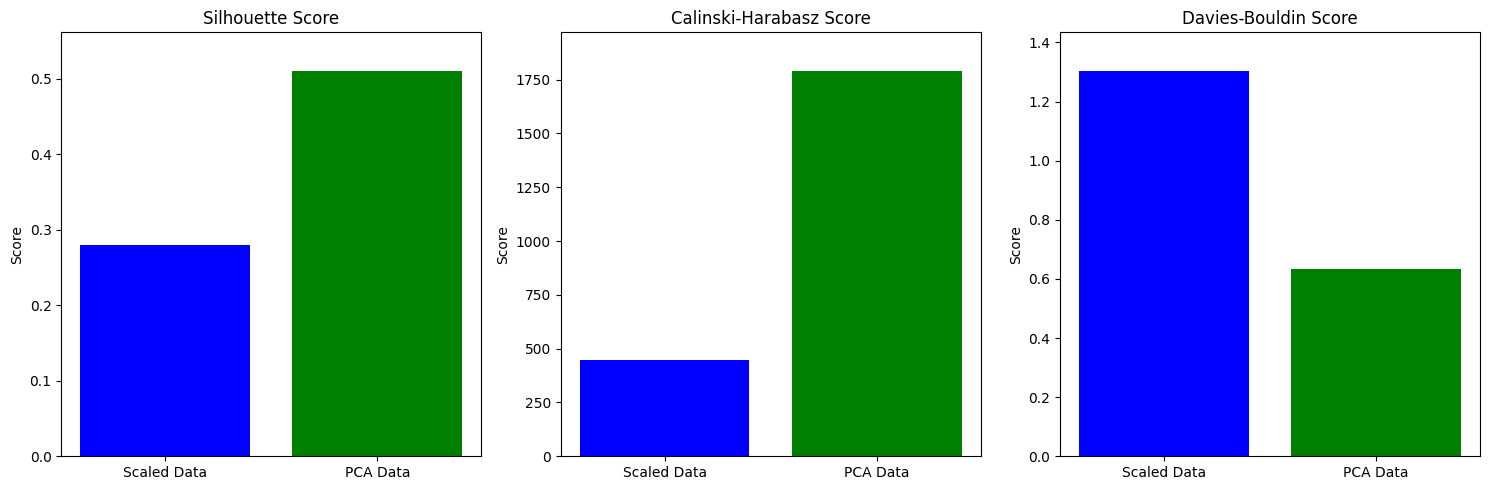

In [20]:
# Calculating the scores for Scaled Data Clustering
silhouette_scaled = silhouette_score(scaled_data, data['Cluster_Scaled'])
calinski_scaled = calinski_harabasz_score(scaled_data, data['Cluster_Scaled'])
davies_scaled = davies_bouldin_score(scaled_data, data['Cluster_Scaled'])

# Calculating the scores for PCA Data Clustering
silhouette_pca = silhouette_score(pca_data, data['Cluster_PCA'])
calinski_pca = calinski_harabasz_score(pca_data, data['Cluster_PCA'])
davies_pca = davies_bouldin_score(pca_data, data['Cluster_PCA'])

scores = {
    'Silhouette Score': [silhouette_scaled, silhouette_pca],
    'Calinski-Harabasz Score': [calinski_scaled, calinski_pca],
    'Davies-Bouldin Score': [davies_scaled, davies_pca]
}

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for ax, (metric, values) in zip(axs, scores.items()):
    ax.bar(['Scaled Data', 'PCA Data'], values, color=['blue', 'green'])
    ax.set_title(metric)
    ax.set_ylabel('Score')
    ax.set_ylim(0, max(values)*1.1)

plt.tight_layout()
plt.show()

The K-means clustering algorithm performed better on PCA-transformed data compared to scaled data. This improvement likely results from PCA's ability to reduce dimensionality and highlight key features, thereby enhancing clustering effectiveness by focusing on the most significant patterns in the data.

# Final Results

In [17]:
# Pca Data Cluster Means
data.groupby('Cluster_PCA').mean().head()

,TotalSteps,TotalDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,Cluster_Scaled
Cluster_PCA,,,,,,,,
0,"8,672.06",6.15,18.51,16.04,247.83,924.74,"2,414.79",1.76
1,"15,169.62",11.24,63.32,29.30,238.33,902.71,"2,935.61",1.15
2,"2,502.96",1.72,2.71,2.45,102.38,"1,117.71","1,843.00",0.47


**Cluster 0** represents a moderately active group, averaging 8,672 steps and 6.15 miles. This cluster engages in a variety of physical activities, with a notable focus on lightly active minutes (248 minutes on average). Despite a relatively high average sedentary time of 925 minutes, individuals in this cluster manage to burn an average of 2,415 calories, indicating a balanced engagement across different activity intensities.

**Cluster 1** is the most active cluster, with members averaging 15,170 steps and 11.24 miles. They are significantly engaged in very active pursuits, averaging 63 very active minutes and 29 fairly active minutes. This cluster also has the lowest sedentary time at 903 minutes, contributing to the highest average caloric expenditure of 2,936 calories. This highlights their high level of physical engagement and efficient activity distribution.

**Cluster 2** is the least active, characterized by the lowest activity levels with an average of only 2,503 steps and 1.72 miles. This cluster's engagement in physical activities is minimal across all intensities, and it records the highest average sedentary time at 1,118 minutes. Correspondingly, they have the lowest average caloric burn at 1,843 calories, suggesting a predominantly sedentary lifestyle.

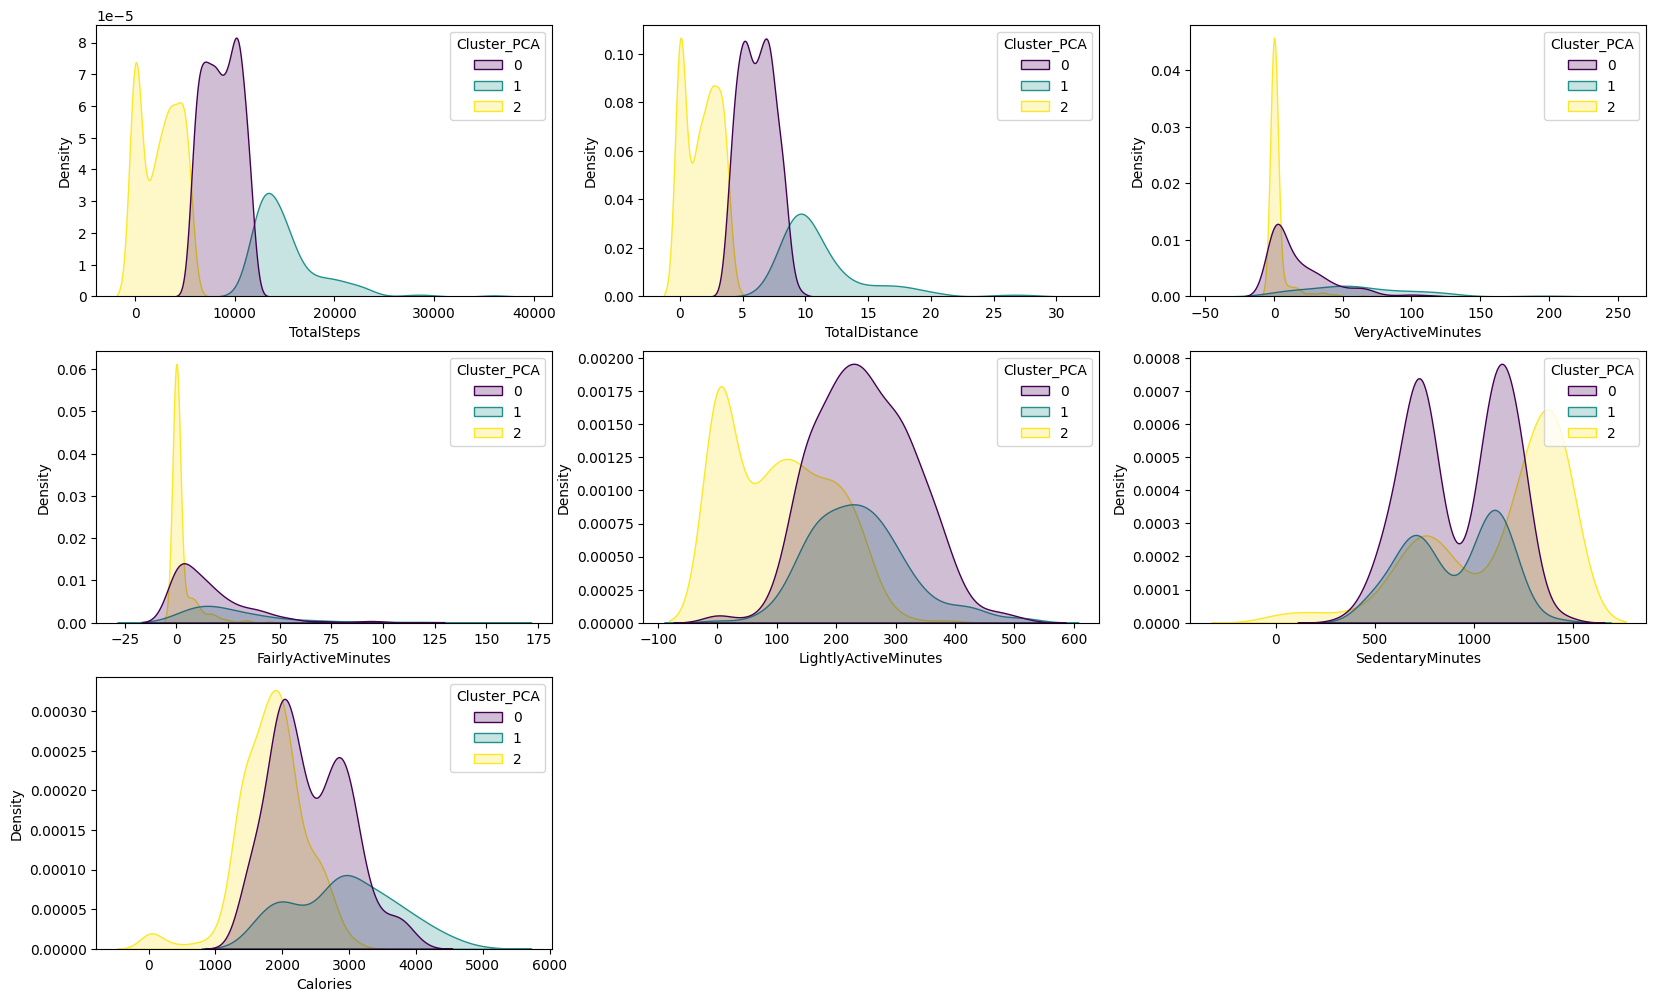

In [18]:
# Visualize cluster distributions across various metrics
plt.figure(figsize=(20,12))

plt.subplot(3, 3, 1)
sns.kdeplot(data=data, x='TotalSteps', hue='Cluster_PCA', fill=True, palette='viridis')
plt.xlabel('TotalSteps')
plt.ylabel('Density')

plt.subplot(3, 3, 2)
sns.kdeplot(data=data, x='TotalDistance', hue='Cluster_PCA', fill=True, palette='viridis')
plt.xlabel('TotalDistance')
plt.ylabel('Density')

plt.subplot(3, 3, 3)
sns.kdeplot(data=data, x='VeryActiveMinutes', hue='Cluster_PCA', fill=True, palette='viridis')
plt.xlabel('VeryActiveMinutes')
plt.ylabel('Density')

plt.subplot(3, 3, 4)
sns.kdeplot(data=data, x='FairlyActiveMinutes', hue='Cluster_PCA', fill=True, palette='viridis')
plt.xlabel('FairlyActiveMinutes')
plt.ylabel('Density')

plt.subplot(3, 3, 5)
sns.kdeplot(data=data, x='LightlyActiveMinutes', hue='Cluster_PCA', fill=True, palette='viridis')
plt.xlabel('LightlyActiveMinutes')
plt.ylabel('Density')

plt.subplot(3, 3, 6)
sns.kdeplot(data=data, x='SedentaryMinutes', hue='Cluster_PCA', fill=True, palette='viridis')
plt.xlabel('SedentaryMinutes')
plt.ylabel('Density')

plt.subplot(3, 3, 7)
sns.kdeplot(data=data, x='Calories', hue='Cluster_PCA', fill=True, palette='viridis')
plt.xlabel('Calories')
plt.ylabel('Density')

plt.show()